In [1]:
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta,TH
from IPython.display import display
import calendar
import seaborn as sns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 100)

df = pd.read_csv('BANKNIFTY_2017_OPT.csv')
df1 = pd.read_csv('BANKNIFTY_2017_FUT.csv')

final_df = pd.concat([df,df1],ignore_index=True)

final_df['instrument'] = final_df['Ticker'].apply(lambda x : (x[:9]))
final_df['datetime'] = final_df['Date'] + ' ' + final_df['Time']
final_df['Type'].fillna('FUT', inplace=True)
final_df['datetime'] = final_df['datetime'].apply(lambda x : datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
final_df['Time'] = final_df['Time'].apply(lambda x : datetime.datetime.strptime(x,'%H:%M:%S').time())
final_df['Date'] = final_df['Date'].apply(lambda x : datetime.datetime.strptime(x,'%Y-%m-%d').date())
final_df['Expiry'] = final_df['Expiry'].apply(lambda x : datetime.datetime.strptime(x,'%Y-%m-%d').date())

intraday_trade_log = pd.DataFrame(columns=['Entry_Datetime','Future_Traded_Price','ATM','Days_to_Expiry','CE_Symbol_Leg1','CE_Entry_Price1','CE_Exit_Price1','CE_Exit_Datetime1','CE_Symbol_Leg2','CE_Entry_Price2','CE_Exit_Price2','CE_Exit_Datetime2','CE_Upper_Hedge_Symbol','CE_Upper_Hedge_Entry_Price','CE_Upper_Hedge_Exit_Price','CE_Upper_Hedge_Exit_Datetime','CE_Below_Hedge_Symbol','CE_Below_Hedge_Entry_Price','CE_Below_Hedge_Exit_Price','CE_Below_Hedge_Exit_Datetime','PnL'])

# intraday_trade_log = pd.DataFrame(columns=['Entry_Datetime','Future_Traded_Price','ATM','CE_Symbol','CE_Entry_Price','CE_Exit_Price','CE_Exit_Datetime','PE_Symbol','PE_Entry_Price','PE_Exit_Price','PE_Exit_Datetime','CE_Hedge_Symbol','CE_Hedge_Entry_Price','CE_Hedge_Exit_Price','CE_Hedge_Exit_Datetime','PE_Hedge_Symbol','PE_Hedge_Entry_Price','PE_Hedge_Exit_Price','PE_Hedge_Exit_Datetime','PnL'])
#intraday_trade_log = pd.DataFrame(columns=['Entry_Datetime','Future_Traded_Price','ATM','CE_Symbol','CE_Entry_Price','CE_Exit_Price','CE_Exit_Datetime','PE_Symbol','PE_Entry_Price','PE_Exit_Price','PE_Exit_Datetime','PnL'])
date_list = final_df['Date'].unique()

In [2]:
try:
    for dts in date_list:
        #print(f"**********************{dts}**********************************")
        if dts ==  datetime.date(2017,7,10) or dts == datetime.date(2017,7,20) or dts == datetime.date(2017,10,19):
            pass
        else:
            intraday_data = final_df[(final_df['Date']==dts)]
            
            entry_time = datetime.datetime.combine(intraday_data['Date'].iloc[0], datetime.time(10, 29,59))
            exit_time = datetime.datetime.combine(intraday_data['Date'].iloc[0], datetime.time(15, 19,59))
                                                                                               
            future_expiry_offset = 'I'
            instrument = 'BANKNIFTY'
            base = 100                                                                                   
            
            futures_data = intraday_data[(intraday_data['Type'] == 'FUT') & (intraday_data['instrument'] == instrument) & (intraday_data['Contract'] == future_expiry_offset)]
            futures_data.reset_index(drop=True,inplace=True)
            
            atm = futures_data[futures_data['datetime'] == entry_time]['Adj_Open'].iloc[0]
            atm = base*round(atm/base)        

            ce_upper_hedge = atm + 100
            ce_below_hedge = atm - 100

            nearest_expiry = intraday_data['Date'].iloc[0] + relativedelta(weekday=TH(+1))
            #print(ce_hedge,atm,pe_hedge,nearest_expiry)

            ce_data_leg1 = intraday_data[(intraday_data['Type'] == 'CE') & (intraday_data['instrument'] == instrument) & ((intraday_data['Expiry'] == nearest_expiry)|(intraday_data['Expiry'] == nearest_expiry - datetime.timedelta(days=1))|(intraday_data['Expiry'] == nearest_expiry - datetime.timedelta(days=2))) & (intraday_data['Strike'] == atm)]
            ce_data_leg1.reset_index(drop=True,inplace=True)
                    
            ce_data_leg2 = intraday_data[(intraday_data['Type'] == 'CE') & (intraday_data['instrument'] == instrument) & ((intraday_data['Expiry'] == nearest_expiry)|(intraday_data['Expiry'] == nearest_expiry - datetime.timedelta(days=1))|(intraday_data['Expiry'] == nearest_expiry - datetime.timedelta(days=2))) & (intraday_data['Strike'] == atm)]
            ce_data_leg2.reset_index(drop=True,inplace=True)

            ce_upper_hedge_data = intraday_data[(intraday_data['Type'] == 'CE') & (intraday_data['instrument'] == instrument) & ((intraday_data['Expiry'] == nearest_expiry)|(intraday_data['Expiry'] == nearest_expiry - datetime.timedelta(days=1))|(intraday_data['Expiry'] == nearest_expiry - datetime.timedelta(days=2))) & (intraday_data['Strike'] == ce_upper_hedge)]
            ce_upper_hedge_data.reset_index(drop=True,inplace=True)
                    
            ce_below_hedge_data = intraday_data[(intraday_data['Type'] == 'PE') & (intraday_data['instrument'] == instrument) & ((intraday_data['Expiry'] == nearest_expiry)|(intraday_data['Expiry'] == nearest_expiry - datetime.timedelta(days=1))|(intraday_data['Expiry'] == nearest_expiry - datetime.timedelta(days=2))) & (intraday_data['Strike'] == ce_below_hedge)]
            ce_below_hedge_data.reset_index(drop=True,inplace=True)

            #print(len(ce_data),len(ce_hedge_data),len(pe_data),len(ce_hedge_data))
            
            ce_symbol_leg1 = ce_data_leg1['Ticker'].iloc[0]
            ce_symbol_leg2 = ce_data_leg2['Ticker'].iloc[0]
            ce_upper_hedge_symbol = ce_upper_hedge_data['Ticker'].iloc[0]
            ce_below_hedge_symbol = ce_below_hedge_data['Ticker'].iloc[0]

            #print(ce_symbol,pe_symbol,ce_hedge_symbol,pe_hedge_symbol)

            futures_data = futures_data[['datetime','Adj_Close']].set_index('datetime')
            ce_data_leg1 = ce_data_leg1[['datetime','Adj_Close']].set_index('datetime')
            ce_data_leg2 = ce_data_leg2[['datetime','Adj_Close']].set_index('datetime')
            ce_upper_hedge_data = ce_upper_hedge_data[['datetime','Adj_Close']].set_index('datetime')
            ce_below_hedge_data = ce_below_hedge_data[['datetime','Adj_Close']].set_index('datetime')


            final_intraday_data = pd.concat([futures_data,ce_data_leg1,ce_data_leg2,ce_upper_hedge_data,ce_below_hedge_data],axis=1)
            final_intraday_data.columns = ['futures_close','ce_close1','ce_close2','ce_upper_hedge_close','ce_below_hedge_close']
            final_intraday_data = final_intraday_data.ffill()
            final_intraday_data.reset_index(inplace=True)

            traded_prices = final_intraday_data[final_intraday_data['datetime'] == entry_time]
            
            futures_entry_price = traded_prices['futures_close'].iloc[0]
            ce_entry_price1 = traded_prices['ce_close1'].iloc[0]
            ce_entry_price2 = traded_prices['ce_close2'].iloc[0]
            ce_upper_hedge_entry_price = traded_prices['ce_upper_hedge_close'].iloc[0]
            ce_below_hedge_entry_price = traded_prices['ce_below_hedge_close'].iloc[0]
            #print(f"Fut Price = {futures_entry_price} CE Price = {ce_entry_price} PE Price = {pe_entry_price} CE_Hedge Price = {ce_hedge_entry_price} PE_Hedge Price = {pe_hedge_entry_price}")
            
            
            stoploss_percent = 30/100
            combi_prem = ce_entry_price1 + ce_entry_price2
            combi_sl = combi_prem + (combi_prem *stoploss_percent )

            tg_percent = 80/100
            combi_tg = combi_prem - (combi_prem *tg_percent )
            #print(f"ce_entry_price = {ce_entry_price},pe_entry_price = {pe_entry_price} and Combi Prem = {combi_prem } and combi sl = {combi_sl} TG sl = {combi_tg}")

            entry_time_index = final_intraday_data[final_intraday_data['datetime'] == entry_time].index[0]
            exit_time_index = final_intraday_data[final_intraday_data['datetime'] == exit_time].index[0]

            final_intraday_data =final_intraday_data[entry_time_index:exit_time_index+1]

            final_intraday_data['ce_pnl1'] = 0
            final_intraday_data['ce_pnl1'] = 0
            final_intraday_data['ce_upper_hedge_pnl'] = 0
            final_intraday_data['ce_below_hedge_pnl'] = 0
            final_intraday_data['total_pnl'] = 0
            final_intraday_data.reset_index(drop=True,inplace=True)
        
            stoploss_counter = 0
            tg_counter = 0
            ce_exit_datetime1 = ''
            ce_exit_datetime2 = ''
            ce_upper_hedge_exit_datetime = ''
            ce_below_hedge_exit_datetime = ''
            ce_exit_price1= 0
            ce_exit_price2= 0
            ce_upper_hedge_exit_price= 0
            ce_below_hedge_exit_price= 0
            ce_pnl1 = 0
            ce_pnl2 = 0
            ce_upper_hedge_pnl = 0
            ce_below_hedge_pnl = 0
            pnl = 0

            for index,row in final_intraday_data.iterrows():
                ce_ltp1 = row['ce_close1']
                ce_ltp2 = row['ce_close2']
                combi_premium = ce_ltp1 + ce_ltp2
                ce_upper_hedge_ltp = row['ce_upper_hedge_close']
                ce_below_hedge_ltp = row['ce_below_hedge_close']

                if (stoploss_counter == 0) & (tg_counter == 0) & (row['datetime'] == exit_time):
                    print('Checking condition for 03:20 time limit')
                    ce_pnl1 = ce_entry_price1 - ce_ltp1
                    ce_pnl2 = ce_entry_price2 - ce_ltp2
                    ce_upper_hedge_pnl = ce_upper_hedge_entry_price - ce_upper_hedge_ltp
                    ce_below_hedge_pnl = ce_below_hedge_entry_price - ce_below_hedge_ltp
                    pnl = ce_pnl1 + ce_pnl2 + ce_upper_hedge_pnl + ce_below_hedge_pnl
                    
                    stoploss_counter =1
                    tg_counter =1
            
                    ce_exit_datetime1 = row['datetime']
                    ce_exit_datetime2 = row['datetime']
                    ce_upper_exit_datetime= row['datetime']
                    ce_below_exit_datetime= row['datetime']
            
                    ce_exit_price1 = ce_ltp1
                    ce_exit_price2 = ce_ltp2
                    ce_upper_exit_price = ce_upper_hedge_ltp
                    ce_below_exit_price = ce_below_hedge_ltp
            
                    final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
                    final_intraday_data.loc[index,'ce_pnl2'] = ce_pnl2
                    final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
                    final_intraday_data.loc[index,'ce_below_hedge_pnl'] = ce_below_hedge_pnl        
                    print('Exited at 03:20 condition')
                    
                    break
                #Condition for Stop Loss
                elif (combi_premium >= combi_sl) & (stoploss_counter == 0) & (tg_counter == 0):
                    print('Checking condition  for Stop Loss')
                    ce_pnl1 = ce_entry_price1 - ce_ltp1
                    ce_pnl2 = ce_entry_price2 - ce_ltp2
                    ce_upper_hedge_pnl = ce_upper_hedge_entry_price - ce_upper_hedge_ltp
                    ce_below_hedge_pnl = ce_below_hedge_entry_price - ce_below_hedge_ltp
                    pnl = ce_pnl1 + ce_pnl2 + ce_upper_hedge_pnl + ce_below_hedge_pnl
            
                    stoploss_counter = 1
            
                    ce_exit_datetime1 = row['datetime']
                    ce_exit_datetime2 = row['datetime']
                    ce_upper_exit_datetime= row['datetime']
                    ce_below_exit_datetime= row['datetime']
                    
                    ce_exit_price1 = ce_ltp1
                    ce_exit_price2 = ce_ltp2
                    ce_upper_exit_price = ce_upper_hedge_ltp
                    ce_below_exit_price = ce_below_hedge_ltp
            
                    final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
                    final_intraday_data.loc[index,'ce_pnl2'] = ce_pnl2
                    final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
                    final_intraday_data.loc[index,'ce_below_hedge_pnl'] = ce_below_hedge_pnl     
            
                    print('Stop loss of 30% got hit')
                    break

                elif ( combi_premium <= combi_tg) & (stoploss_counter == 0) & (tg_counter == 0):
                    print('Checking condition for Target')
                    ce_pnl1 = ce_entry_price1 - ce_ltp1
                    ce_pnl2 = ce_entry_price2 - ce_ltp2
                    ce_upper_hedge_pnl = ce_upper_hedge_entry_price - ce_upper_hedge_ltp
                    ce_below_hedge_pnl = ce_below_hedge_entry_price - ce_below_hedge_ltp
                    pnl = ce_pnl1 + ce_pnl2 + ce_upper_hedge_pnl + ce_below_hedge_pnl
            
                    tg_counter = 1
            
                    ce_exit_datetime1 = row['datetime']
                    ce_exit_datetime2 = row['datetime']
                    ce_upper_exit_datetime= row['datetime']
                    ce_below_exit_datetime= row['datetime']
                    
                    ce_exit_price1 = ce_ltp1
                    ce_exit_price2 = ce_ltp2
                    ce_upper_exit_price = ce_upper_hedge_ltp
                    ce_below_exit_price = ce_below_hedge_ltp
            
                    final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
                    final_intraday_data.loc[index,'ce_pnl2'] = ce_pnl2
                    final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
                    final_intraday_data.loc[index,'ce_below_hedge_pnl'] = ce_below_hedge_pnl  
            
                    print('Target of 30% got hit')
                    break
                    
            new_row = pd.DataFrame({'Entry_Datetime': [entry_time],
                                    'Future_Traded_Price': [futures_entry_price],
                                    'ATM': [atm],
                                    'Days_to_Expiry': [(nearest_expiry - entry_time.date()).days],
                                    'CE_Symbol_Leg1': [ce_symbol_leg1],
                                    'CE_Entry_Price1': [ce_entry_price1],
                                    'CE_Exit_Price1': [ce_exit_price1],
                                    'CE_Exit_Datetime1': [ce_exit_datetime1],
                                    'CE_Symbol_Leg2': [ce_symbol_leg2],
                                    'CE_Entry_Price2': [ce_entry_price2],
                                    'CE_Exit_Price2': [ce_exit_price2],
                                    'CE_Exit_Datetime2': [ce_exit_datetime2],
                                    'CE_Upper_Hedge_Symbol':[ce_upper_hedge_symbol],
                                    'CE_Upper_Hedge_Entry_Price':[ce_upper_hedge_entry_price],
                                    'CE_Upper_Hedge_Exit_Price':[ce_upper_hedge_exit_price],
                                    'CE_Upper_Hedge_Exit_Datetime':[ce_upper_hedge_exit_datetime],
                                    'CE_Below_Hedge_Symbol':[ce_below_hedge_symbol],
                                    'CE_Below_Hedge_Entry_Price':[ce_below_hedge_entry_price],
                                    'CE_Below_Hedge_Exit_Price':[ce_below_hedge_exit_price],
                                    'CE_Below_Hedge_Exit_Datetime':[ce_below_hedge_exit_datetime],
                                    'PnL': [pnl]})


                # Concatenate the new row DataFrame with intraday_trade_log
            #intraday_trade_log = pd.concat([intraday_trade_log, new_row], ignore_index=True)
            intraday_trade_log = pd.concat([intraday_trade_log, new_row], ignore_index=True)

except Exception as e:
    print(e)

Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10.350000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1.9500000000000028' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_below_hedge_pnl'] = ce_below_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:224: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determ

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition for Target
Target of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '28.65' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '21.65' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.7999999999999972' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  fina

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-6.800000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.9499999999999993' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '14.85' has dtype incompatible with int64, please explicitly cast to a compatible dtype 

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '11.400000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '6.950000000000003' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype fi

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-18.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-9.55' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '18.249999999999996' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-41.45000000000002' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-31.19999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '27.450000000000003' has dtype incompatible with int64, please explicitly cast to a compa

Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '27.60000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-19.799999999999997' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_below_hedge_pnl'] = ce_below_hedge_pnl


Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '43.6' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '26.949999999999996' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-18.150000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype f

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '67.15' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '49.650000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-71.94999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype f

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-21.10000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-4.550000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '23.7' has dtype incompatible with int64, please explicitly cast to a compatible dtype fi

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-58.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-49.650000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '21.950000000000017' has dtype incompatible with int64, please explicitly cast to a compatible dtype 

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-59.05000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-51.150000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '72.60000000000002' has dtype incompatible with int64, please explicitly cast to a compa

Checking condition for Target
Target of 30% got hit
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '32.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '12.450000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-55.400000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype f

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '35.349999999999994' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '29.599999999999994' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-20.400000000000006' has dtype incompatible with int64, please explicitly cast to a comp

Checking condition for Target
Target of 30% got hit
Checking condition for Target
Target of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '92.44999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '67.8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:194: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-87.99999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype fir

Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '34.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '28.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-15.550000000000011' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '4.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '4.599999999999994' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '12.150000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype firs

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '56.55' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '35.300000000000004' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-35.35' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  fina

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-53.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-44.099999999999994' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '38.150000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype 

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-42.80000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-28.099999999999994' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '29.049999999999997' has dtype incompatible with int64, please explicitly cast to a comp

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-20.300000000000004' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-10.200000000000003' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '20.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype 

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '23.25' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '16.15' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-10.349999999999994' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  fina

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-12.549999999999997' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-3.299999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '13.25' has dtype incompatible with int64, please explicitly cast to a compatible dtype 

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '19.05000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '11.899999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-9.549999999999997' has dtype incompatible with int64, please explicitly cast to a compat

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '15.050000000000004' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '9.05' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '8.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_i

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.950000000000017' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-12.800000000000011' has dtype incompatible with int64, please explicitly cast to a compatible dtype fir

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition for Target
Target of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '9.850000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '5.550000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1.9500000000000028' has dtype incompatible with int64, please explicitly cast to a compat

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '6.900000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '6.549999999999997' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.4000000000000057' has dtype incompatible with int64, please explicitly cast to a compat

Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '14.700000000000003' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '7.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-17.549999999999997' has dtype incompatible with int64, please explicitly cast to a compatible dtype f

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '37.85' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '18.05' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-21.700000000000003' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  fina

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '11.099999999999994' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '8.149999999999991' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-10.650000000000006' has dtype incompatible with int64, please explicitly cast to a compa

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1.2999999999999972' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.3999999999999986' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10.600000000000001' has dtype incompatible with int64, please explicitly cast to a comp

Checking condition for Target
Target of 30% got hit
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '25.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '6.7' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:194: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '9.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-24.85000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-11.950000000000003' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '49.3' has dtype incompatible with int64, please explicitly cast to a compatible dtype f

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '37.15' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '25.8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '30.7' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-15.150000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '29.699999999999996' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_below_hedge_pnl'] = ce_below_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-36.000000000000014' has dtype incompatible with int64, please ex

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition for Target
Target of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-24.950000000000003' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-13.399999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '21.599999999999998' has dtype incompatible with int64, please explicitly cast to a com

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition for Target
Target of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-6.549999999999997' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-3.1500000000000057' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '25.80000000000001' has dtype incompatible with int64, please explicitly cast to a compa

Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '29.199999999999996' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '22.85' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '17.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-12.950000000000003' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-4.750000000000002' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '5.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype fi

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-31.599999999999994' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-22.65' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '24.299999999999997' has dtype incompatible with int64, please explicitly cast to a compatible dtype

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.3499999999999943' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '5.950000000000003' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '22.300000000000004' has dtype incompatible with int64, please explicitly cast to a compat

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-26.900000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-18.150000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '40.599999999999994' has dtype incompatible with int64, please explicitly cast to a com

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '15.650000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '14.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '20.099999999999994' has dtype incompatible with int64, please explicitly cast to a compatible dtype fi

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '28.300000000000004' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-30.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_below_hedge_pnl'] = ce_below_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '7.400000000000006' has dtype incompatible with int64, please explicitly cast t

Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-9.400000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-5.6000000000000085' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '20.450000000000003' has dtype incompatible with int64, please explicitly cast to a comp

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '9.299999999999997' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '8.799999999999997' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '18.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype firs

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '37.64999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '25.949999999999996' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-33.70000000000002' has dtype incompatible with int64, please explicitly cast to a compat

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-26.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '22.949999999999996' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_below_hedge_pnl'] = ce_below_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.20000000000000284' has dtype incompatible with int64, please explicitly cast to a compatible dtyp

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-15.399999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-3.3' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '17.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final

Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '46.85000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '31.499999999999993' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-39.349999999999994' has dtype incompatible with int64, please explicitly cast to a compa

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-42.150000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-27.799999999999997' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '23.35' has dtype incompatible with int64, please explicitly cast to a compatible dtype

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-25.25' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-7.800000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '13.65' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  fina

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-55.349999999999994' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-39.250000000000014' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '44.45' has dtype incompatible with int64, please explicitly cast to a compatible dtype

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition for Target
Target of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-27.80000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-16.25' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '39.599999999999994' has dtype incompatible with int64, please explicitly cast to a compatible dtype 

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-3.4000000000000057' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.15000000000000568' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '15.899999999999991' has dtype incompatible with int64, please explicitly cast to a co

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '4.849999999999994' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '3.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '4.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_int

Checking condition for Target
Target of 30% got hit
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '40.25' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '13.45' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:194: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '6.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '45.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '32.099999999999994' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-17.199999999999996' has dtype incompatible with int64, please explicitly cast to a compatible dtype f

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition for Target
Target of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-35.94999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-23.349999999999994' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '42.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype f

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-3.5999999999999943' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10.400000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype f

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '24.150000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '17.249999999999993' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '5.450000000000003' has dtype incompatible with int64, please explicitly cast to a compat

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-22.950000000000003' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-8.700000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '3.950000000000001' has dtype incompatible with int64, please explicitly cast to a compa

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '61.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-54.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_below_hedge_pnl'] = ce_below_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '3.0500000000000114' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-17.250000000000007' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-7.100000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '14.95' has dtype incompatible with int64, please explicitly cast to a compatible dtype 

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-32.150000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-22.60000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '30.599999999999994' has dtype incompatible with int64, please explicitly cast to a comp

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-29.25' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-18.35' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '15.899999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  fin

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-5.300000000000011' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-3.200000000000003' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '8.950000000000003' has dtype incompatible with int64, please explicitly cast to a compat

Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-15.100000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-8.25' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '12.450000000000003' has dtype incompatible with int64, please explicitly cast to a compatible dtype 

Checking condition for Target
Target of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '37.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '12.7' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:194: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '6.3999999999999995' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_i

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-49.900000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-35.45' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '35.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  fin

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '31.89999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '23.300000000000004' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-8.599999999999994' has dtype incompatible with int64, please explicitly cast to a compat

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.0999999999999943' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6499999999999915' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '11.799999999999997' has dtype incompatible with int64, please explicitly cast to a compa

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-13.149999999999991' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-7.599999999999994' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '18.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype f

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-17.849999999999994' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-10.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '9.649999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype f

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-35.95' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-28.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '21.299999999999997' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  fin

Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '72.15' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '57.75000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '46.099999999999994' has dtype incompatible with int64, please explicitly cast to a compatible dtype fi

Checking condition for Target
Target of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '15.6' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '4.6499999999999995' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:194: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.8999999999999986' has dtype incompatible with int64, please explicitly cast to a compatible dtype fi

Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-33.94999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-24.099999999999994' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '31.599999999999994' has dtype incompatible with int64, please explicitly cast to a comp

Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '8.299999999999997' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.0999999999999943' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_below_hedge_pnl'] = ce_below_hedge_pnl


Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-29.599999999999994' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-20.849999999999994' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '29.449999999999996' has dtype incompatible with int64, please explicitly cast to a com

Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-15.149999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-7.25' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '15.699999999999996' has dtype incompatible with int64, please explicitly cast to a compatible dtype 

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-61.55000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-50.400000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '49.349999999999994' has dtype incompatible with int64, please explicitly cast to a comp

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition for Target
Target of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-25.650000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-15.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '21.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  fin

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-33.150000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-26.450000000000017' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '34.999999999999986' has dtype incompatible with int64, please explicitly cast to a com

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-47.45000000000002' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-34.8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '33.14999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype fi

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-14.700000000000003' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-6.049999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '15.700000000000001' has dtype incompatible with int64, please explicitly cast to a comp

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '55.55000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '44.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-27.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-26.650000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-13.949999999999996' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10.100000000000001' has dtype incompatible with int64, please explicitly cast to a com

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '36.45' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '26.9' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-40.05' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_dat

Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-23.200000000000003' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-13.649999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '20.099999999999994' has dtype incompatible with int64, please explicitly cast to a com

Checking condition for Target
Target of 30% got hit
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '23.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '6.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:194: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '4.049999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_in

Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-28.80000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-21.099999999999994' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '21.799999999999997' has dtype incompatible with int64, please explicitly cast to a comp

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1.1499999999999915' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.5500000000000043' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '21.099999999999994' has dtype incompatible with int64, please explicitly cast to a comp

Checking condition for Target
Target of 30% got hit
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '46.849999999999994' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '15.899999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:194: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '6.15' has dtype incompatible with int64, please explicitly cast to a compatible dtype fi

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '6.299999999999997' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '6.149999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10.25' has dtype incompatible with int64, please explicitly cast to a compatible dtype fir

Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '21.400000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '14.200000000000003' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-4.949999999999999' has dtype incompatible with int64, please explicitly cast to a compa

Checking condition for Target
Target of 30% got hit
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '34.85' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '12.65' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:194: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '15.8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data

Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-18.94999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '40.150000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_below_hedge_pnl'] = ce_below_hedge_pnl


Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-54.25' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-39.3' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '30.9' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_dat

Checking condition for Target
Target of 30% got hit
Checking condition for Target
Target of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '72.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '42.8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:194: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-99.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.

Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '53.599999999999994' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '40.599999999999994' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-49.55000000000001' has dtype incompatible with int64, please explicitly cast to a compa

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '6.599999999999994' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '8.900000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '28.700000000000017' has dtype incompatible with int64, please explicitly cast to a compati

Checking condition for Target
Target of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '18.45' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '5.3' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:194: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-18.200000000000003' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_

Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '14.550000000000011' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10.700000000000003' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '3.1500000000000057' has dtype incompatible with int64, please explicitly cast to a compa

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '15.950000000000003' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '13.499999999999993' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1.8499999999999943' has dtype incompatible with int64, please explicitly cast to a comp

Checking condition for Target
Target of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '32.849999999999994' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:194: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-91.55' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_below_hedge_pnl'] = ce_below_hedge_pnl


Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-11.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-2.9000000000000004' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '11.549999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype 

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '17.849999999999994' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '13.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '6.150000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype fi

Checking condition for Target
Target of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '33.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '15.000000000000002' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:194: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '5.449999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype fir

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition for 03:20 time limit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-20.349999999999994' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-13.349999999999994' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '35.95000000000002' has dtype incompatible with int64, please explicitly cast to a comp

Exited at 03:20 condition
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-31.89999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-21.400000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '28.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype f

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '30.55000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '28.19999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '8.099999999999994' has dtype incompatible with int64, please explicitly cast to a compatib

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '4.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.950000000000003' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '8.199999999999989' has dtype incompatible with int64, please explicitly cast to a compatible dtype firs

Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-28.650000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-17.299999999999997' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '47.3' has dtype incompatible with int64, please explicitly cast to a compatible dtype 

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-17.85' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '5.699999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_below_hedge_pnl'] = ce_below_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-47.45000000000002' has dtype incompatible with int64, please explicitly cast to a compatible dtype f

Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-44.650000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-34.39999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '26.950000000000003' has dtype incompatible with int64, please explicitly cast to a comp

Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '59.39999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '46.60000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-22.799999999999997' has dtype incompatible with int64, please explicitly cast to a compat

Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-20.69999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-13.899999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '21.950000000000003' has dtype incompatible with int64, please explicitly cast to a comp

Checking condition for Target
Target of 30% got hit
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '22.45' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '6.8999999999999995' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:194: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-64.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final

Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '42.44999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '32.39999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-30.35000000000001' has dtype incompatible with int64, please explicitly cast to a compati

Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-34.70000000000002' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-22.299999999999997' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '38.8' has dtype incompatible with int64, please explicitly cast to a compatible dtype f

Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '34.349999999999994' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-5.299999999999997' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_below_hedge_pnl'] = ce_below_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-8.55' has dtype incompatible with int64, please explicitly cast to a compatible dtype f

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '66.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '59.099999999999994' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-22.400000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype f

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '37.699999999999996' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '27.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-30.700000000000003' has dtype incompatible with int64, please explicitly cast to a compatible dtype f

Checking condition for Target
Target of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '5.6' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:194: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-22.7' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_below_hedge_pnl'] = ce_below_hedge_pnl


Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9000000000000057' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '4.299999999999997' has dtype incompatible with int64, please explicitly cast to a compatible dtype fir

Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-59.80000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-44.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '38.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '45.35' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '29.8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-29.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data

Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-12.900000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-4.499999999999998' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '14.299999999999997' has dtype incompatible with int64, please explicitly cast to a comp

Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '66.35' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '49.300000000000004' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-142.15' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  fin

Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '40.25' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '30.650000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-35.94999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype f

Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-39.94999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-30.150000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '58.500000000000014' has dtype incompatible with int64, please explicitly cast to a comp

Checking condition for Target
Target of 30% got hit
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '73.95' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '47.55' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:194: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-88.65' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_da

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-12.299999999999983' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-8.549999999999997' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '28.549999999999997' has dtype incompatible with int64, please explicitly cast to a comp

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '24.450000000000003' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '16.200000000000003' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-14.549999999999997' has dtype incompatible with int64, please explicitly cast to a comp

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-12.349999999999998' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '3.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '64.3' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '52.099999999999994' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '47.05' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-8.100000000000023' has dtype incompatible with int64, please explicitly cast to a compatible dtype f

Checking condition  for Stop Loss
Stop loss of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-21.150000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-14.600000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '11.649999999999999' has dtype incompatible with int64, please explicitly cast to a com

Checking condition  for Stop Loss
Stop loss of 30% got hit
Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-13.05' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-4.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '17.299999999999997' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final

Checking condition for 03:20 time limit
Exited at 03:20 condition
Checking condition for Target
Target of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-24.049999999999997' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-14.900000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '26.15' has dtype incompatible with int64, please explicitly cast to a compatible dtype

Checking condition for Target
Target of 30% got hit


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '12.799999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:194: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '32.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_below_hedge_pnl'] = ce_below_hedge_pnl


Checking condition for 03:20 time limit
Exited at 03:20 condition


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_pnl1'] = ce_pnl1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '7.899999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_intraday_data.loc[index,'ce_upper_hedge_pnl'] = ce_upper_hedge_pnl
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\701159735.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.799999999999997' has dtype incompatible with int64, please explicitly cast to a compatible dtype firs

In [3]:
intraday_trade_log

,Entry_Datetime,Future_Traded_Price,ATM,Days_to_Expiry,CE_Symbol_Leg1,CE_Entry_Price1,CE_Exit_Price1,CE_Exit_Datetime1,CE_Symbol_Leg2,CE_Entry_Price2,CE_Exit_Price2,CE_Exit_Datetime2,CE_Upper_Hedge_Symbol,CE_Upper_Hedge_Entry_Price,CE_Upper_Hedge_Exit_Price,CE_Upper_Hedge_Exit_Datetime,CE_Below_Hedge_Symbol,CE_Below_Hedge_Entry_Price,CE_Below_Hedge_Exit_Price,CE_Below_Hedge_Exit_Datetime,PnL
0,2017-01-02 10:29:59,18067.95,18100,3,BANKNIFTY05JAN1718100CE.NFO,89.95,73.95,2017-01-02 15:19:59,BANKNIFTY05JAN1718100CE.NFO,89.95,73.95,2017-01-02 15:19:59,BANKNIFTY05JAN1718200CE.NFO,59.35,0,,BANKNIFTY05JAN1718000PE.NFO,118.45,0,,40.40
1,2017-01-03 10:29:59,18107.00,18100,2,BANKNIFTY05JAN1718100CE.NFO,90.30,61.65,2017-01-03 15:19:59,BANKNIFTY05JAN1718100CE.NFO,90.30,61.65,2017-01-03 15:19:59,BANKNIFTY05JAN1718200CE.NFO,58.15,0,,BANKNIFTY05JAN1718000PE.NFO,89.05,0,,78.15
2,2017-01-04 10:29:59,18048.05,18100,1,BANKNIFTY05JAN1718100CE.NFO,55.50,11.05,2017-01-04 14:58:59,BANKNIFTY05JAN1718100CE.NFO,55.50,11.05,2017-01-04 14:58:59,BANKNIFTY05JAN1718200CE.NFO,29.75,0,,BANKNIFTY05JAN1718000PE.NFO,82.00,0,,68.10
3,2017-01-05 10:29:59,18079.70,18100,0,BANKNIFTY05JAN1718100CE.NFO,20.00,26.80,2017-01-05 11:50:59,BANKNIFTY05JAN1718100CE.NFO,20.00,26.80,2017-01-05 11:50:59,BANKNIFTY05JAN1718200CE.NFO,4.15,0,,BANKNIFTY05JAN1718000PE.NFO,28.50,0,,0.30
4,2017-01-06 10:29:59,18340.00,18300,6,BANKNIFTY12JAN1718300CE.NFO,129.00,109.70,2017-01-06 15:19:59,BANKNIFTY12JAN1718300CE.NFO,129.00,109.70,2017-01-06 15:19:59,BANKNIFTY12JAN1718400CE.NFO,86.80,0,,BANKNIFTY12JAN1718200PE.NFO,97.20,0,,50.60
5,2017-01-09 10:29:59,18359.10,18400,3,BANKNIFTY12JAN1718400CE.NFO,78.25,66.85,2017-01-09 15:19:59,BANKNIFTY12JAN1718400CE.NFO,78.25,66.85,2017-01-09 15:19:59,BANKNIFTY12JAN1718500CE.NFO,45.25,0,,BANKNIFTY12JAN1718300PE.NFO,110.25,0,,29.00
6,2017-01-10 10:29:59,18361.75,18400,2,BANKNIFTY12JAN1718400CE.NFO,64.45,86.15,2017-01-10 15:18:59,BANKNIFTY12JAN1718400CE.NFO,64.45,86.15,2017-01-10 15:18:59,BANKNIFTY12JAN1718500CE.NFO,33.95,0,,BANKNIFTY12JAN1718300PE.NFO,84.55,0,,-18.65
7,2017-01-11 10:29:59,18625.90,18600,1,BANKNIFTY12JAN1718600CE.NFO,58.35,76.45,2017-01-11 11:03:59,BANKNIFTY12JAN1718600CE.NFO,58.35,76.45,2017-01-11 11:03:59,BANKNIFTY12JAN1718700CE.NFO,24.55,0,,BANKNIFTY12JAN1718500PE.NFO,40.55,0,,-27.50
8,2017-01-12 10:29:59,18860.00,18900,0,BANKNIFTY12JAN1718900CE.NFO,21.15,28.65,2017-01-12 10:52:59,BANKNIFTY12JAN1718900CE.NFO,21.15,28.65,2017-01-12 10:52:59,BANKNIFTY12JAN1719000CE.NFO,6.60,0,,BANKNIFTY12JAN1718800PE.NFO,26.40,0,,-7.70
9,2017-01-13 10:29:59,18830.00,18800,6,BANKNIFTY19JAN1718800CE.NFO,131.70,173.15,2017-01-13 11:32:59,BANKNIFTY19JAN1718800CE.NFO,131.70,173.15,2017-01-13 11:32:59,BANKNIFTY19JAN1718900CE.NFO,92.65,0,,BANKNIFTY19JAN1718700PE.NFO,95.00,0,,-86.65


In [4]:
#intraday_trade_log['Entry_Datetime'] = intraday_trade_log['Entry_Datetime'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
intraday_trade_log['Date'] = intraday_trade_log['Entry_Datetime'].apply(lambda x: x.date())

<Axes: >

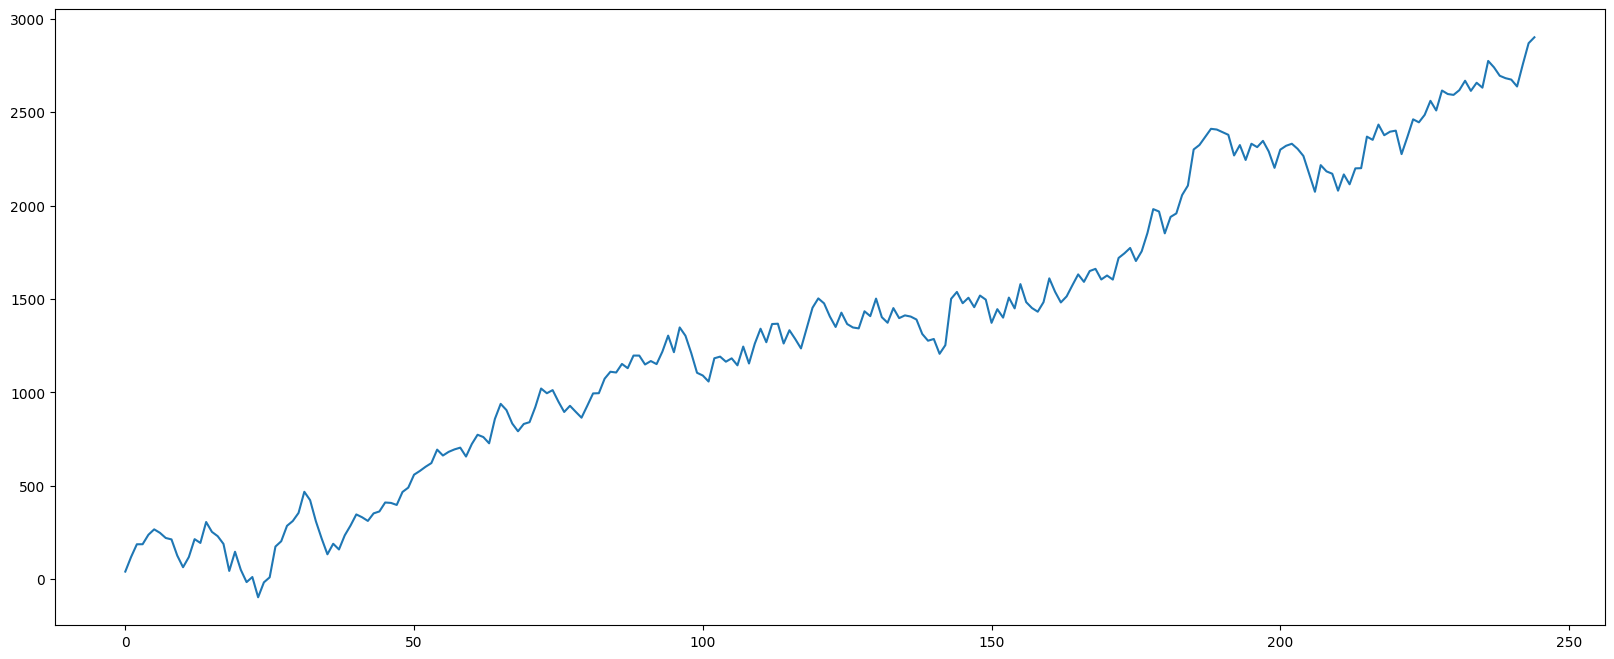

In [5]:
plt.figure(figsize=(20,8))
intraday_trade_log['PnL'].cumsum().plot()

In [6]:
initial_capital = 1000000
intraday_trade_log['Quantity'] = 25

In [7]:
intraday_trade_log['Entry_Price'] = intraday_trade_log['CE_Entry_Price1']+intraday_trade_log['CE_Entry_Price2']
intraday_trade_log['Exit_Price'] = intraday_trade_log['CE_Exit_Price1']+intraday_trade_log['CE_Exit_Price1']

In [8]:
intraday_trade_log['Entry_Including_Slippage'] = intraday_trade_log['Entry_Price'] - (intraday_trade_log['Entry_Price']*0.02)
intraday_trade_log['Exit_Including_Slippage'] = intraday_trade_log['Exit_Price'] + (intraday_trade_log['Exit_Price']*0.02) 

In [9]:
intraday_trade_log['PnL_Including_Slippages'] = (intraday_trade_log['Entry_Including_Slippage']-intraday_trade_log['Exit_Including_Slippage'])*intraday_trade_log['Quantity']

In [10]:
intraday_trade_log['PnL_Including_Slippages_Cumulative_Sum'] = intraday_trade_log['PnL_Including_Slippages'].cumsum()

In [11]:
intraday_trade_log['Equity'] = 0
intraday_trade_log['Rate_of_Return'] = 0

In [12]:
intraday_trade_log

,Entry_Datetime,Future_Traded_Price,ATM,Days_to_Expiry,CE_Symbol_Leg1,CE_Entry_Price1,CE_Exit_Price1,CE_Exit_Datetime1,CE_Symbol_Leg2,CE_Entry_Price2,CE_Exit_Price2,CE_Exit_Datetime2,CE_Upper_Hedge_Symbol,CE_Upper_Hedge_Entry_Price,CE_Upper_Hedge_Exit_Price,CE_Upper_Hedge_Exit_Datetime,CE_Below_Hedge_Symbol,CE_Below_Hedge_Entry_Price,CE_Below_Hedge_Exit_Price,CE_Below_Hedge_Exit_Datetime,PnL,Date,Quantity,Entry_Price,Exit_Price,Entry_Including_Slippage,Exit_Including_Slippage,PnL_Including_Slippages,PnL_Including_Slippages_Cumulative_Sum,Equity,Rate_of_Return
0,2017-01-02 10:29:59,18067.95,18100,3,BANKNIFTY05JAN1718100CE.NFO,89.95,73.95,2017-01-02 15:19:59,BANKNIFTY05JAN1718100CE.NFO,89.95,73.95,2017-01-02 15:19:59,BANKNIFTY05JAN1718200CE.NFO,59.35,0,,BANKNIFTY05JAN1718000PE.NFO,118.45,0,,40.40,2017-01-02,25,179.9,147.9,176.302,150.858,636.10,636.10,0,0
1,2017-01-03 10:29:59,18107.00,18100,2,BANKNIFTY05JAN1718100CE.NFO,90.30,61.65,2017-01-03 15:19:59,BANKNIFTY05JAN1718100CE.NFO,90.30,61.65,2017-01-03 15:19:59,BANKNIFTY05JAN1718200CE.NFO,58.15,0,,BANKNIFTY05JAN1718000PE.NFO,89.05,0,,78.15,2017-01-03,25,180.6,123.3,176.988,125.766,1280.55,1916.65,0,0
2,2017-01-04 10:29:59,18048.05,18100,1,BANKNIFTY05JAN1718100CE.NFO,55.50,11.05,2017-01-04 14:58:59,BANKNIFTY05JAN1718100CE.NFO,55.50,11.05,2017-01-04 14:58:59,BANKNIFTY05JAN1718200CE.NFO,29.75,0,,BANKNIFTY05JAN1718000PE.NFO,82.00,0,,68.10,2017-01-04,25,111.0,22.1,108.780,22.542,2155.95,4072.60,0,0
3,2017-01-05 10:29:59,18079.70,18100,0,BANKNIFTY05JAN1718100CE.NFO,20.00,26.80,2017-01-05 11:50:59,BANKNIFTY05JAN1718100CE.NFO,20.00,26.80,2017-01-05 11:50:59,BANKNIFTY05JAN1718200CE.NFO,4.15,0,,BANKNIFTY05JAN1718000PE.NFO,28.50,0,,0.30,2017-01-05,25,40.0,53.6,39.200,54.672,-386.80,3685.80,0,0
4,2017-01-06 10:29:59,18340.00,18300,6,BANKNIFTY12JAN1718300CE.NFO,129.00,109.70,2017-01-06 15:19:59,BANKNIFTY12JAN1718300CE.NFO,129.00,109.70,2017-01-06 15:19:59,BANKNIFTY12JAN1718400CE.NFO,86.80,0,,BANKNIFTY12JAN1718200PE.NFO,97.20,0,,50.60,2017-01-06,25,258.0,219.4,252.840,223.788,726.30,4412.10,0,0
5,2017-01-09 10:29:59,18359.10,18400,3,BANKNIFTY12JAN1718400CE.NFO,78.25,66.85,2017-01-09 15:19:59,BANKNIFTY12JAN1718400CE.NFO,78.25,66.85,2017-01-09 15:19:59,BANKNIFTY12JAN1718500CE.NFO,45.25,0,,BANKNIFTY12JAN1718300PE.NFO,110.25,0,,29.00,2017-01-09,25,156.5,133.7,153.370,136.374,424.90,4837.00,0,0
6,2017-01-10 10:29:59,18361.75,18400,2,BANKNIFTY12JAN1718400CE.NFO,64.45,86.15,2017-01-10 15:18:59,BANKNIFTY12JAN1718400CE.NFO,64.45,86.15,2017-01-10 15:18:59,BANKNIFTY12JAN1718500CE.NFO,33.95,0,,BANKNIFTY12JAN1718300PE.NFO,84.55,0,,-18.65,2017-01-10,25,128.9,172.3,126.322,175.746,-1235.60,3601.40,0,0
7,2017-01-11 10:29:59,18625.90,18600,1,BANKNIFTY12JAN1718600CE.NFO,58.35,76.45,2017-01-11 11:03:59,BANKNIFTY12JAN1718600CE.NFO,58.35,76.45,2017-01-11 11:03:59,BANKNIFTY12JAN1718700CE.NFO,24.55,0,,BANKNIFTY12JAN1718500PE.NFO,40.55,0,,-27.50,2017-01-11,25,116.7,152.9,114.366,155.958,-1039.80,2561.60,0,0
8,2017-01-12 10:29:59,18860.00,18900,0,BANKNIFTY12JAN1718900CE.NFO,21.15,28.65,2017-01-12 10:52:59,BANKNIFTY12JAN1718900CE.NFO,21.15,28.65,2017-01-12 10:52:59,BANKNIFTY12JAN1719000CE.NFO,6.60,0,,BANKNIFTY12JAN1718800PE.NFO,26.40,0,,-7.70,2017-01-12,25,42.3,57.3,41.454,58.446,-424.80,2136.80,0,0
9,2017-01-13 10:29:59,18830.00,18800,6,BANKNIFTY19JAN1718800CE.NFO,131.70,173.15,2017-01-13 11:32:59,BANKNIFTY19JAN1718800CE.NFO,131.70,173.15,2017-01-13 11:32:59,BANKNIFTY19JAN1718900CE.NFO,92.65,0,,BANKNIFTY19JAN1718700PE.NFO,95.00,0,,-86.65,2017-01-13,25,263.4,346.3,258.132,353.226,-2377.35,-240.55,0,0


In [13]:
for i in range(len(list(intraday_trade_log.index))):

    if i == 0:
        intraday_trade_log['Equity'].iloc[i] = initial_capital + intraday_trade_log['PnL_Including_Slippages'].iloc[i]
        intraday_trade_log['Rate_of_Return'].iloc[i] = (intraday_trade_log['PnL_Including_Slippages'].iloc[i]/initial_capital)*100
    else:
        intraday_trade_log['Equity'].iloc[i] = intraday_trade_log['Equity'].iloc[i-1] + intraday_trade_log['PnL_Including_Slippages'].iloc[i]
        intraday_trade_log['Rate_of_Return'].iloc[i] = (intraday_trade_log['PnL_Including_Slippages'].iloc[i]/intraday_trade_log['Equity'].iloc[i-1])*100

C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\138033945.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intraday_trade_log['Equity'].iloc[i] = initial_capital + intraday_trade_log['PnL_Including_Slippages'].iloc[i]
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\138033945.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1000636.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  intraday_trade_log['Equity'].iloc[i] = initial_capital + intraday_trade_log['PnL_Including_Slippages'].iloc[i]
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\138033945.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

In [14]:
intraday_trade_log

,Entry_Datetime,Future_Traded_Price,ATM,Days_to_Expiry,CE_Symbol_Leg1,CE_Entry_Price1,CE_Exit_Price1,CE_Exit_Datetime1,CE_Symbol_Leg2,CE_Entry_Price2,CE_Exit_Price2,CE_Exit_Datetime2,CE_Upper_Hedge_Symbol,CE_Upper_Hedge_Entry_Price,CE_Upper_Hedge_Exit_Price,CE_Upper_Hedge_Exit_Datetime,CE_Below_Hedge_Symbol,CE_Below_Hedge_Entry_Price,CE_Below_Hedge_Exit_Price,CE_Below_Hedge_Exit_Datetime,PnL,Date,Quantity,Entry_Price,Exit_Price,Entry_Including_Slippage,Exit_Including_Slippage,PnL_Including_Slippages,PnL_Including_Slippages_Cumulative_Sum,Equity,Rate_of_Return
0,2017-01-02 10:29:59,18067.95,18100,3,BANKNIFTY05JAN1718100CE.NFO,89.95,73.95,2017-01-02 15:19:59,BANKNIFTY05JAN1718100CE.NFO,89.95,73.95,2017-01-02 15:19:59,BANKNIFTY05JAN1718200CE.NFO,59.35,0,,BANKNIFTY05JAN1718000PE.NFO,118.45,0,,40.40,2017-01-02,25,179.9,147.9,176.302,150.858,636.10,636.10,1000636.10,0.063610
1,2017-01-03 10:29:59,18107.00,18100,2,BANKNIFTY05JAN1718100CE.NFO,90.30,61.65,2017-01-03 15:19:59,BANKNIFTY05JAN1718100CE.NFO,90.30,61.65,2017-01-03 15:19:59,BANKNIFTY05JAN1718200CE.NFO,58.15,0,,BANKNIFTY05JAN1718000PE.NFO,89.05,0,,78.15,2017-01-03,25,180.6,123.3,176.988,125.766,1280.55,1916.65,1001916.65,0.127974
2,2017-01-04 10:29:59,18048.05,18100,1,BANKNIFTY05JAN1718100CE.NFO,55.50,11.05,2017-01-04 14:58:59,BANKNIFTY05JAN1718100CE.NFO,55.50,11.05,2017-01-04 14:58:59,BANKNIFTY05JAN1718200CE.NFO,29.75,0,,BANKNIFTY05JAN1718000PE.NFO,82.00,0,,68.10,2017-01-04,25,111.0,22.1,108.780,22.542,2155.95,4072.60,1004072.60,0.215183
3,2017-01-05 10:29:59,18079.70,18100,0,BANKNIFTY05JAN1718100CE.NFO,20.00,26.80,2017-01-05 11:50:59,BANKNIFTY05JAN1718100CE.NFO,20.00,26.80,2017-01-05 11:50:59,BANKNIFTY05JAN1718200CE.NFO,4.15,0,,BANKNIFTY05JAN1718000PE.NFO,28.50,0,,0.30,2017-01-05,25,40.0,53.6,39.200,54.672,-386.80,3685.80,1003685.80,-0.038523
4,2017-01-06 10:29:59,18340.00,18300,6,BANKNIFTY12JAN1718300CE.NFO,129.00,109.70,2017-01-06 15:19:59,BANKNIFTY12JAN1718300CE.NFO,129.00,109.70,2017-01-06 15:19:59,BANKNIFTY12JAN1718400CE.NFO,86.80,0,,BANKNIFTY12JAN1718200PE.NFO,97.20,0,,50.60,2017-01-06,25,258.0,219.4,252.840,223.788,726.30,4412.10,1004412.10,0.072363
5,2017-01-09 10:29:59,18359.10,18400,3,BANKNIFTY12JAN1718400CE.NFO,78.25,66.85,2017-01-09 15:19:59,BANKNIFTY12JAN1718400CE.NFO,78.25,66.85,2017-01-09 15:19:59,BANKNIFTY12JAN1718500CE.NFO,45.25,0,,BANKNIFTY12JAN1718300PE.NFO,110.25,0,,29.00,2017-01-09,25,156.5,133.7,153.370,136.374,424.90,4837.00,1004837.00,0.042303
6,2017-01-10 10:29:59,18361.75,18400,2,BANKNIFTY12JAN1718400CE.NFO,64.45,86.15,2017-01-10 15:18:59,BANKNIFTY12JAN1718400CE.NFO,64.45,86.15,2017-01-10 15:18:59,BANKNIFTY12JAN1718500CE.NFO,33.95,0,,BANKNIFTY12JAN1718300PE.NFO,84.55,0,,-18.65,2017-01-10,25,128.9,172.3,126.322,175.746,-1235.60,3601.40,1003601.40,-0.122965
7,2017-01-11 10:29:59,18625.90,18600,1,BANKNIFTY12JAN1718600CE.NFO,58.35,76.45,2017-01-11 11:03:59,BANKNIFTY12JAN1718600CE.NFO,58.35,76.45,2017-01-11 11:03:59,BANKNIFTY12JAN1718700CE.NFO,24.55,0,,BANKNIFTY12JAN1718500PE.NFO,40.55,0,,-27.50,2017-01-11,25,116.7,152.9,114.366,155.958,-1039.80,2561.60,1002561.60,-0.103607
8,2017-01-12 10:29:59,18860.00,18900,0,BANKNIFTY12JAN1718900CE.NFO,21.15,28.65,2017-01-12 10:52:59,BANKNIFTY12JAN1718900CE.NFO,21.15,28.65,2017-01-12 10:52:59,BANKNIFTY12JAN1719000CE.NFO,6.60,0,,BANKNIFTY12JAN1718800PE.NFO,26.40,0,,-7.70,2017-01-12,25,42.3,57.3,41.454,58.446,-424.80,2136.80,1002136.80,-0.042371
9,2017-01-13 10:29:59,18830.00,18800,6,BANKNIFTY19JAN1718800CE.NFO,131.70,173.15,2017-01-13 11:32:59,BANKNIFTY19JAN1718800CE.NFO,131.70,173.15,2017-01-13 11:32:59,BANKNIFTY19JAN1718900CE.NFO,92.65,0,,BANKNIFTY19JAN1718700PE.NFO,95.00,0,,-86.65,2017-01-13,25,263.4,346.3,258.132,353.226,-2377.35,-240.55,999759.45,-0.237228


In [15]:
win_rate = round(len(intraday_trade_log[intraday_trade_log['PnL_Including_Slippages']>0])/len(intraday_trade_log),2)
print(f'Win Rate:{win_rate}')

Win Rate:0.45


In [16]:
mean_win = intraday_trade_log[intraday_trade_log['PnL_Including_Slippages']>0]['PnL_Including_Slippages'].mean()
mean_loss = intraday_trade_log[intraday_trade_log['PnL_Including_Slippages']<0]['PnL_Including_Slippages'].mean()
risk_reward = abs(mean_win/mean_loss)
expectancy = round((win_rate*risk_reward) - ((1-win_rate)*1),2)

print(f'Expectancy:{expectancy}')

Expectancy:-0.07


In [17]:
number_of_trading_days_in_a_year = 252
risk_free_interest_rate = 5
mean = intraday_trade_log['Rate_of_Return'].mean() * number_of_trading_days_in_a_year - risk_free_interest_rate
sigma = intraday_trade_log['Rate_of_Return'].std() * np.sqrt(number_of_trading_days_in_a_year)
sharpe_ratio = round(mean/sigma,2)

print(f'Sharpe Ratio:{sharpe_ratio}')

Sharpe Ratio:-2.52


In [18]:
downside_standard_deviation = intraday_trade_log[intraday_trade_log['Rate_of_Return']<0]['Rate_of_Return'].std() * np.sqrt(number_of_trading_days_in_a_year)
sortino_ratio = round(mean/downside_standard_deviation,2)
print(f'Sortino Ratio:{sortino_ratio}')

Sortino Ratio:-4.68


In [19]:
intraday_trade_log['Drawdown'] = intraday_trade_log['PnL_Including_Slippages_Cumulative_Sum'] - intraday_trade_log['PnL_Including_Slippages_Cumulative_Sum'].cummax()
max_drawdown = round(intraday_trade_log['Drawdown'].min(),2)
print(f'Max Drawdown [Rs.] :{max_drawdown}')

max_drawdown_percent = round(max_drawdown/intraday_trade_log[intraday_trade_log['Drawdown'] == intraday_trade_log['Drawdown'].min()]['Equity'].iloc[0]*100,2)
print(f'Max Drawdown Percent:{max_drawdown_percent}')

Max Drawdown [Rs.] :-32937.25
Max Drawdown Percent:-3.39


In [20]:
intraday_trade_log['Recovery'] = 0
for i in range(len(intraday_trade_log)):
    if (intraday_trade_log['Drawdown'].iloc[i] < 0):
        intraday_trade_log['Recovery'].iloc[i] = intraday_trade_log['Recovery'].iloc[i-1] + 1
recovery_trades = intraday_trade_log['Recovery'].max()

print(f'Number of trades done from Drawdown to achieve a new peak: {recovery_trades}')

intraday_trade_log_equity_high = intraday_trade_log[intraday_trade_log['Recovery'] == 0]
intraday_trade_log_equity_high['number_days_between_equity_highs'] = (intraday_trade_log_equity_high['Entry_Datetime'] - intraday_trade_log_equity_high['Entry_Datetime'].shift())
recovery_days = int(intraday_trade_log_equity_high['number_days_between_equity_highs'].apply(lambda x: x.days).max())
print(f'Number of Days taken from Drawdown to achieve a new peak: {recovery_days}')

Number of trades done from Drawdown to achieve a new peak: 239
Number of Days taken from Drawdown to achieve a new peak: 3


C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\3154857752.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intraday_trade_log['Recovery'].iloc[i] = intraday_trade_log['Recovery'].iloc[i-1] + 1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\3154857752.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intraday_trade_log['Recovery'].iloc[i] = intraday_trade_log['Recovery'].iloc[i-1] + 1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\3154857752.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyda

In [21]:
print(f'Number of trades done from Drawdown to achieve a new peak: {recovery_trades}')
print(f'Number of Days taken from Drawdown to achieve a new peak: {recovery_days}')

Number of trades done from Drawdown to achieve a new peak: 239
Number of Days taken from Drawdown to achieve a new peak: 3


In [22]:
number_of_trading_days_for_this_backtest = (intraday_trade_log.iloc[-1]['Entry_Datetime'].date() - intraday_trade_log.iloc[0]['Entry_Datetime'].date()).days
cagr = (((intraday_trade_log.iloc[-1]['Equity']/initial_capital)**(1/(number_of_trading_days_for_this_backtest/365)))-1)*100
cagr = round(cagr,2)

print(f'CAGR:{cagr}')

CAGR:-2.06


In [23]:
calmar_ratio = round(abs(cagr/max_drawdown_percent),2)

print(f'Calmar Ratio:{calmar_ratio}')

Calmar Ratio:0.61


In [24]:
backtest_start_date = intraday_trade_log.iloc[0]['Entry_Datetime'].date()
backtest_start_date


datetime.date(2017, 1, 2)

In [25]:
backtest_end_date = intraday_trade_log.iloc[-1]['Entry_Datetime'].date()
backtest_end_date

datetime.date(2017, 12, 29)

In [26]:
number_of_trades = len(intraday_trade_log)
number_of_trades

245

In [27]:
number_of_wins = len(intraday_trade_log[intraday_trade_log['PnL_Including_Slippages']>0])
print(f'Number of Wins: {number_of_wins}')

number_of_losses = len(intraday_trade_log[intraday_trade_log['PnL_Including_Slippages']<0])
print(f'Number of Losses: {number_of_losses}')

Number of Wins: 111
Number of Losses: 134


In [28]:
average_profit_per_trade = round(intraday_trade_log[intraday_trade_log['PnL_Including_Slippages'] > 0]['PnL_Including_Slippages'].mean(),2)
print(f'Average Profit Per Trade: {average_profit_per_trade}')

average_loss_per_trade = round(intraday_trade_log[intraday_trade_log['PnL_Including_Slippages'] < 0]['PnL_Including_Slippages'].mean(),2)
print(f'Average Loss Per Trade: {average_loss_per_trade}')

Average Profit Per Trade: 1504.26
Average Loss Per Trade: -1397.98


In [29]:
max_pnl = round(intraday_trade_log['PnL_Including_Slippages'].max(),2)
print(f'Max PnL Point:{max_pnl}')

min_pnl = round(intraday_trade_log['PnL_Including_Slippages'].min(),2)
print(f'Min PnL Point:{min_pnl}')

Max PnL Point:4487.35
Min PnL Point:-5285.35


In [30]:
median_of_trade = round(intraday_trade_log['PnL_Including_Slippages'].median(),2)
print(f'Median:{median_of_trade}')

Median:-252.8


In [31]:
gross_profit = intraday_trade_log[intraday_trade_log['PnL_Including_Slippages']>0]['PnL_Including_Slippages'].sum()
gross_loss = intraday_trade_log[intraday_trade_log['PnL_Including_Slippages']<0]['PnL_Including_Slippages'].sum()

profit_factor = round(abs(gross_profit/gross_loss),2)
print(f'Profit Factor:{profit_factor}')

Profit Factor:0.89


In [32]:
outlier_adjusted_profit_factor = round(abs((gross_profit-max_pnl)/gross_loss),2)
print(f'Outlier Adjusted Profit Factor:{outlier_adjusted_profit_factor}')

Outlier Adjusted Profit Factor:0.87


In [33]:
intraday_trade_log['Continuous_Wins'] = 0
intraday_trade_log['Continuous_Losses'] = 0

In [34]:
for i in range(1,len(intraday_trade_log)):
    if intraday_trade_log['PnL_Including_Slippages'].iloc[i-1] > 0:
        intraday_trade_log['Continuous_Wins'].iloc[i] = intraday_trade_log['Continuous_Wins'].iloc[i-1]+1
    if intraday_trade_log['PnL_Including_Slippages'].iloc[i-1] < 0:
        intraday_trade_log['Continuous_Losses'].iloc[i] = intraday_trade_log['Continuous_Losses'].iloc[i-1]+1

C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\1117506453.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intraday_trade_log['Continuous_Wins'].iloc[i] = intraday_trade_log['Continuous_Wins'].iloc[i-1]+1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\1117506453.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intraday_trade_log['Continuous_Wins'].iloc[i] = intraday_trade_log['Continuous_Wins'].iloc[i-1]+1
C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\1117506453.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentat

In [35]:
consecutive_wins = intraday_trade_log['Continuous_Wins'].max()
consecutive_losses = intraday_trade_log['Continuous_Losses'].max()
print(f'Consecutive Wins:{consecutive_wins}')
print(f'Consecutive Losses:{consecutive_losses}')

Consecutive Wins:8
Consecutive Losses:9


In [36]:
metrics = pd.DataFrame(columns=['Backtest Start Date','Backtest End Date','Number of Trades','Number of Wins','Number of Losses','Average Profit','Average Loss','Maximum Profit Points','Maximum Loss Points','Median Trade','Win Rate','Expectancy','Sharpe Ratio','Sortino Ratio','Max Drawdown','Max Drawdown Percent','Days Taken to Recover From Drawdown','Number of Trades to Recover From Drawdown','Calmar','CAGR','Consecutive Wins','Consecutive Losses','Profit Factor (Amount of Profit per unit of Loss)','Outlier Adjusted Profit Factor (Profit Factor except that One Exceptional Biggest Winner)'])

In [37]:
metrics_data = pd.DataFrame({'Backtest Start Date':[backtest_start_date], 
                          'Backtest End Date':[backtest_end_date], 
                          'Number of Trades':[number_of_trades],
                          'Number of Wins':[number_of_wins],
                          'Number of Losses':[number_of_losses],
                          'Average Profit':[average_profit_per_trade],
                          'Average Loss':[average_loss_per_trade],
                          'Maximum Profit Points':[max_pnl],
                          'Maximum Loss Points':[min_pnl],
                          'Median Trade':[median_of_trade],
                          'Win Rate':[win_rate],
                          'Expectancy':[expectancy],
                          'Sharpe Ratio':[sharpe_ratio],
                          'Sortino Ratio':[sortino_ratio],
                          'Max Drawdown':[max_drawdown],
                          'Max Drawdown Percent':[max_drawdown_percent],
                          'Days Taken to Recover From Drawdown':[recovery_days],
                          'Number of Trades to Recover From Drawdown':[recovery_trades],
                          'Calmar':[calmar_ratio],
                          'CAGR':[cagr],
                          'Consecutive Wins':[consecutive_wins],
                          'Consecutive Losses':[consecutive_losses],
                          'Profit Factor (Amount of Profit per unit of Loss)':[profit_factor],
                          'Outlier Adjusted Profit Factor (Profit Factor except that One Exceptional Biggest Winner)':[outlier_adjusted_profit_factor]})
metrics = pd.concat([metrics, metrics_data], ignore_index=True)

C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\2938638605.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics = pd.concat([metrics, metrics_data], ignore_index=True)


In [38]:
metrics

,Backtest Start Date,Backtest End Date,Number of Trades,Number of Wins,Number of Losses,Average Profit,Average Loss,Maximum Profit Points,Maximum Loss Points,Median Trade,Win Rate,Expectancy,Sharpe Ratio,Sortino Ratio,Max Drawdown,Max Drawdown Percent,Days Taken to Recover From Drawdown,Number of Trades to Recover From Drawdown,Calmar,CAGR,Consecutive Wins,Consecutive Losses,Profit Factor (Amount of Profit per unit of Loss),Outlier Adjusted Profit Factor (Profit Factor except that One Exceptional Biggest Winner)
0,2017-01-02,2017-12-29,245,111,134,1504.26,-1397.98,4487.35,-5285.35,-252.8,0.45,-0.07,-2.52,-4.68,-32937.25,-3.39,3,239,0.61,-2.06,8,9,0.89,0.87


In [39]:
returns = intraday_trade_log[['Entry_Datetime','Equity']]
returns.set_index('Entry_Datetime',inplace=True)
returns = returns.resample('M').last()

In [40]:
returns['%Change'] = returns['Equity'].pct_change()*100
returns.reset_index(inplace=True)

In [41]:
returns['Year'] = returns['Entry_Datetime'].apply(lambda x: x.year)
returns['Month'] = returns['Entry_Datetime'].apply(lambda x: x.month)

In [42]:
returns['Month'] = returns['Month'].apply(lambda x: calendar.month_abbr[x])
returns = returns[['Entry_Datetime', '%Change', 'Year', 'Month']]
x = returns.groupby(['Year','Month'])['%Change'].mean()
broad_returns = x.unstack()

In [43]:
broad_returns['Total'] = broad_returns[broad_returns.columns].sum(axis=1)
broad_returns = broad_returns[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Total']]

In [44]:
broad_returns = round(broad_returns,2)
broad_returns

Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Total
Year,,,,,,,,,,,,,
2017,NaN,-0.2,0.44,-0.43,-0.5,-0.12,-1.13,-0.29,0.88,-0.11,-0.54,0.49,-1.51


In [45]:
cm = sns.light_palette('green',as_cmap=True)

In [46]:
drawdown_values = intraday_trade_log['Drawdown'].drop_duplicates().nsmallest(5)
drawdown_df = intraday_trade_log[intraday_trade_log['Drawdown'].isin(list(drawdown_values.values))].copy()

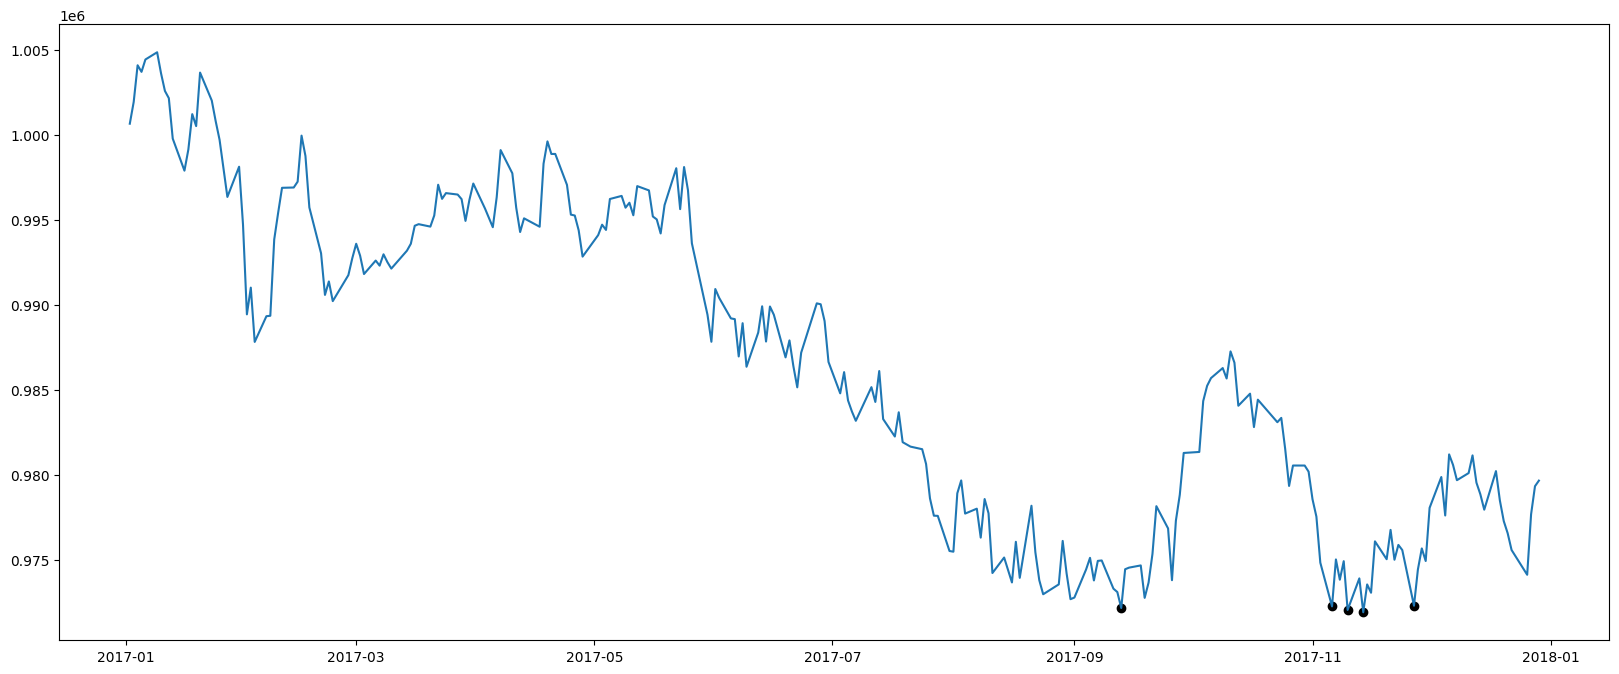

In [47]:
drawdown_figure = plt.figure(figsize=(20,8))
plt.plot(intraday_trade_log['Date'],intraday_trade_log['Equity'])
plt.scatter(drawdown_df['Date'],drawdown_df['Equity'],color='black')

In [48]:
returns['Month-Year'] = returns.apply(lambda x: (str(x['Month']) + ' ' + str(x['Year'])[-2:]).upper(),axis=1)

C:\Users\Rajpurohit\AppData\Local\Temp\ipykernel_9380\2977720538.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 0)` for the same effect.

  sns.barplot(x='Month-Year',y='%Change',data=returns,estimator=np.median,ci=0)


<Axes: xlabel='Month-Year', ylabel='%Change'>

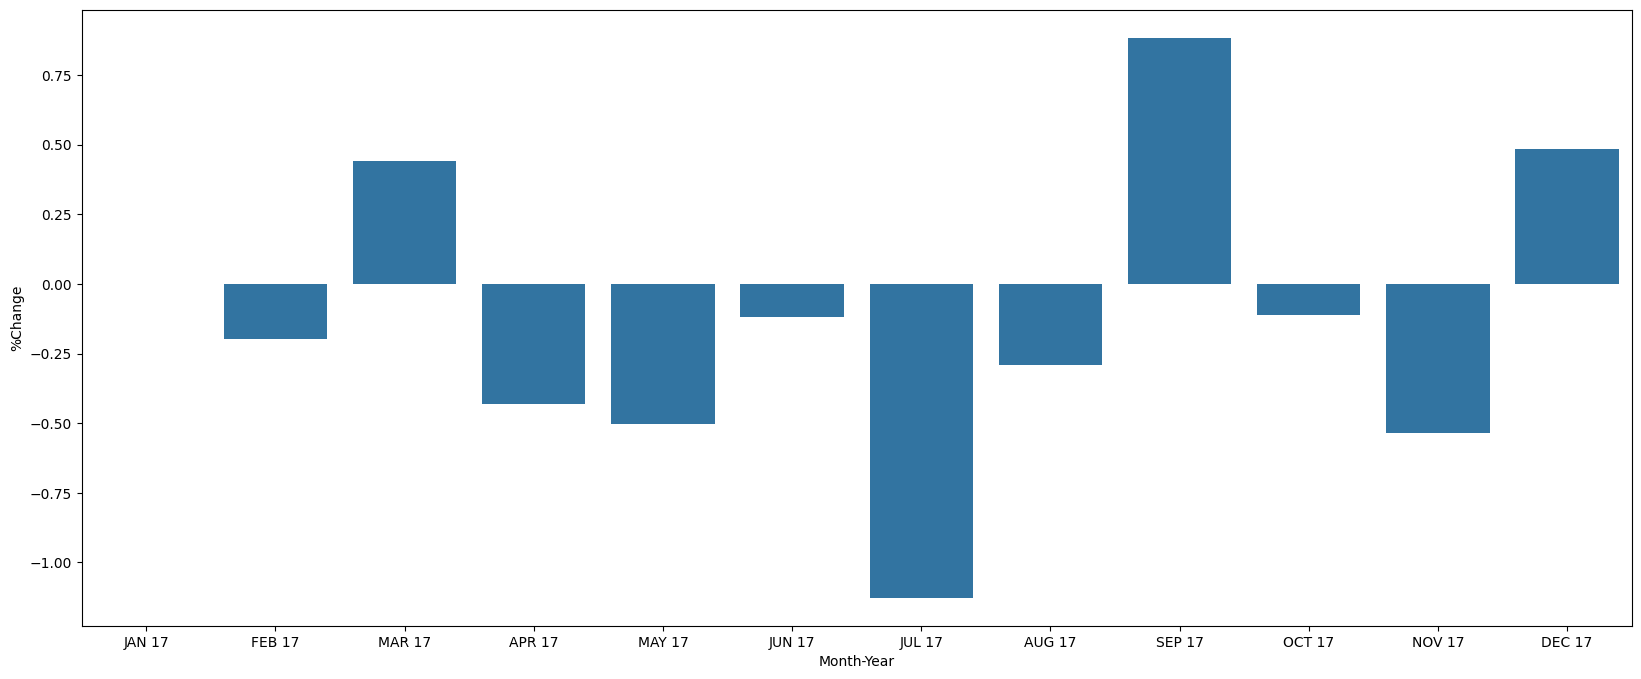

In [49]:
monthly_returns_barplot = plt.figure(figsize=(20,8))
sns.barplot(x='Month-Year',y='%Change',data=returns,estimator=np.median,ci=0)

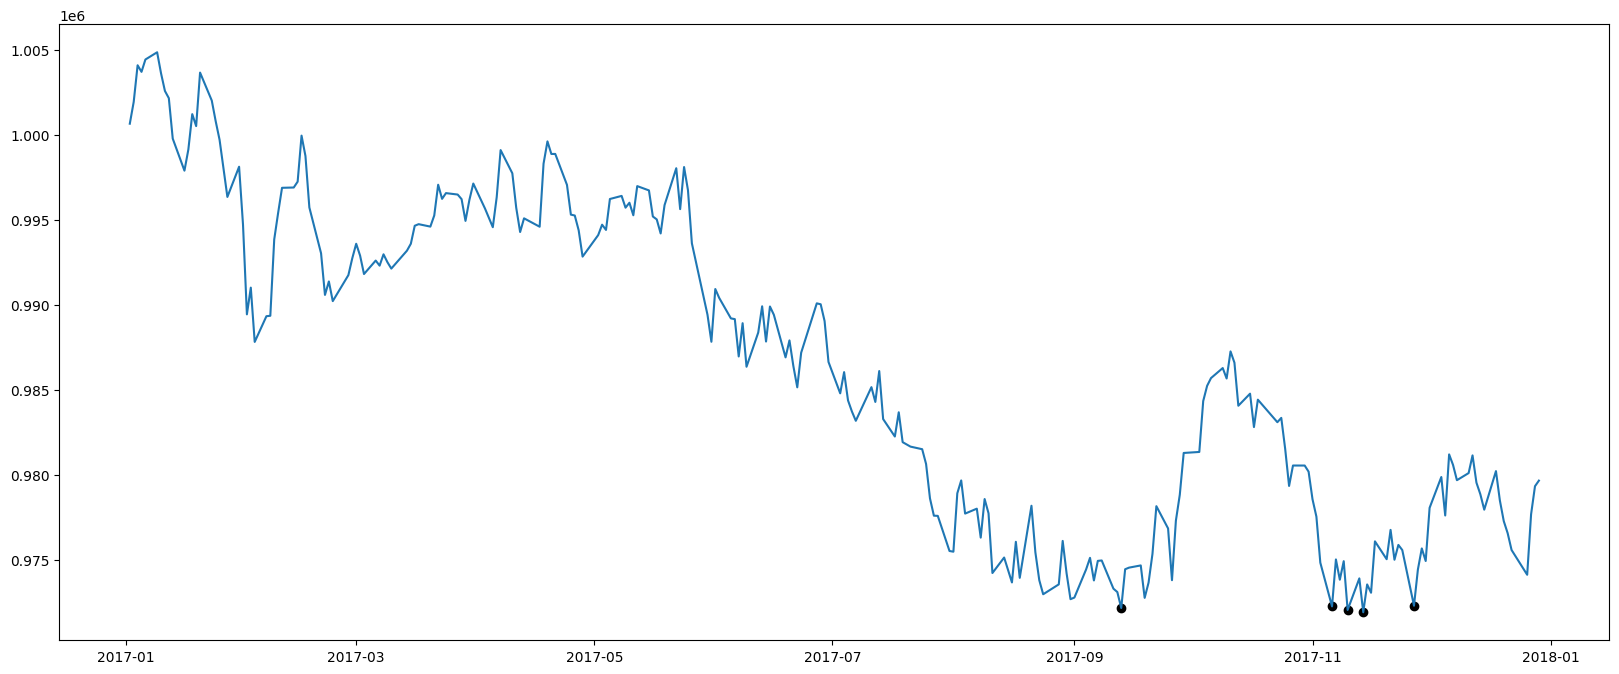

In [50]:
drawdown_figure

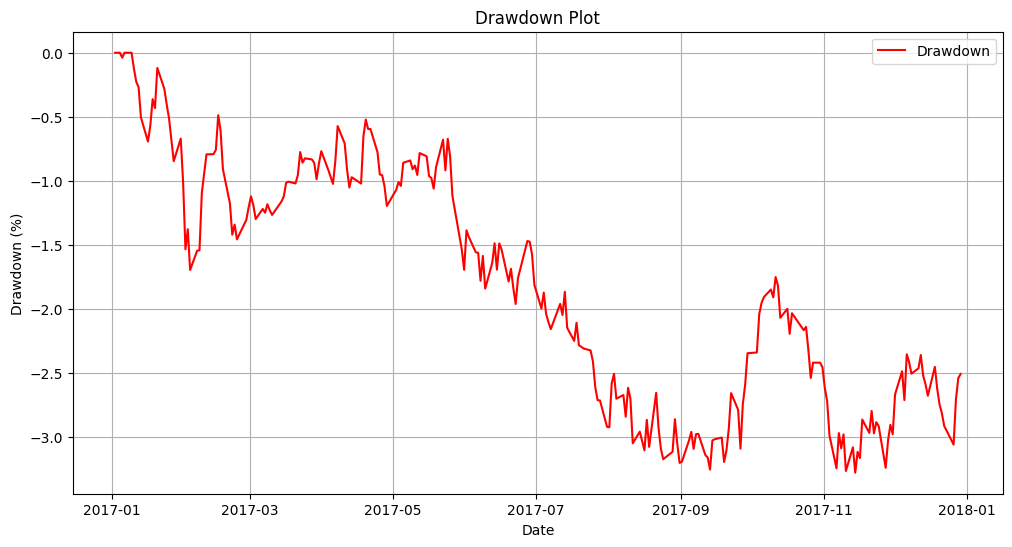

In [51]:
# Sort DataFrame by 'Entry_Datetime' in ascending order
intraday_trade_log.sort_values(by='Entry_Datetime', inplace=True)

# Calculate drawdown as a percentage of the peak equity
intraday_trade_log['Peak'] = intraday_trade_log['Equity'].cummax()
intraday_trade_log['Drawdown'] = (intraday_trade_log['Equity'] - intraday_trade_log['Peak']) / intraday_trade_log['Peak'] * 100

# Plot drawdown
plt.figure(figsize=(12, 6))
plt.plot(intraday_trade_log['Entry_Datetime'], intraday_trade_log['Drawdown'], label='Drawdown', color='red')
plt.title('Drawdown Plot')
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.legend()
plt.grid(True)
plt.show()
